In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
#from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Input
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
#!pip install --upgrade tensorflow-hub
print("imported")

imported


There are 47959 sentences, 35179 words, and 17 labels in the data set

In [11]:
data_ori = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data_ori.drop(['POS'], axis =1) # Remove the part-of-speech tag column
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [12]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [13]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [14]:
# View the statement length distribution of the data set
'''
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
'''
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)


[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [16]:
sentences = getter.sentences
print(len(sentences))

47959


longgest sentence has 104 words


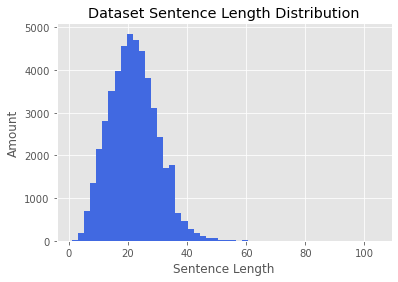

In [23]:
largest_sen = max(len(sen) for sen in sentences)
print('longgest sentence has {} words'.format(largest_sen))
plt.hist([len(sen) for sen in sentences], bins=50,color="royalblue")
plt.title("Dataset Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Amount")
plt.show()

In [25]:
# Set all sentence length to 50
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [30]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 6, 11, 11,  7, 10, 10, 10, 11, 11, 11, 11, 11,  0, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [31]:
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, 
                                          random_state=2018)

In [93]:
#sess = tf.compat.v1.Session()
#with tf.device('/cpu:0'):
sess = tf.Session()
K.set_session(sess)

In [98]:
pip install tensorflow_text#安装的text版本号必须与当前安装的tensorflow-cpu版本号一致，若之前没有安装tensorflow，该命令会自动安装tensorflow-cpu版本

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'tensorflow_text#安装的text版本号必须与当前安装的tensorflow-cpu版本号一致，若之前没有安装tensorflow，该命令会自动安装tensorflow-cpu版本'


In [101]:

import tensorflow_hub as hub
#import tensorflow_text

text_generator = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
#input_texts = ['Sentence 1a. Sentence 1b.', 'Sentence 2a. Sentence 2b. Sentence 2c.']

with tf.Session() as sess:
    sess.run(tf.group(tf.global_variables_initializer(), tf.tables_initializer()))
    #print(sess.run(text_generator(input_texts)))
    # [b'Sentence 1a. Sentence 1b' b'Sentence 2a. Sentence 2b. Sentence 2c']

RuntimeError: variable_scope module_11/ was unused but the corresponding name_scope was already taken.

In [73]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  #使用cpu
#elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

elmo_model = hub.Module("/elmo_2.tar/elmo_2/saved_model", trainable=True)

OSError: /elmo_2.tar/elmo_2/saved_model does not exist.

In [51]:
!pip install tensorflow_text

  Using cached tensorflow-2.7.0-cp38-cp38-win_amd64.whl (430.8 MB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0

ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'D:\\Software\\anaconda\\Lib\\site-packages\\~ensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.

